In [6]:
# dependencies
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import datetime
from mpl_toolkits import mplot3d
from datetime import datetime
from itertools import chain
from matplotlib import cm
import scipy.stats as scistat
import scipy.optimize as sciopt

import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import qrpm_funcs as qf
from mpl_toolkits import mplot3d
from datetime import datetime
from itertools import chain
from matplotlib import cm
import scipy.stats as scistat
import scipy.optimize as sciopt
import scipy.interpolate as scint
from datetime import date
from mpl_toolkits import mplot3d
from datetime import datetime, timedelta
from itertools import chain
import warnings
warnings.filterwarnings("ignore")
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve

In [3]:
def get_spx_vol_data(maturity):
    spx = yf.Ticker('^SPX')
    
    mat_date = date.today() + datetime.timedelta(days=maturity * 365)
    maturities = spx.options
    closest_mat = nearest(maturities, mat_date)
    spx_oc = spx.option_chain(closest_mat).puts
    spx_oc = spx_oc[['strike', 'bid', 'ask']]
    spx_oc = spx_oc.rename(columns={'strike': 'Strike', 'bid': 'Bid', 'ask': 'Ask'})
    spx_oc['Midpoint'] = spx_oc.apply(lambda row: (row.Bid + row.Ask)/2, axis=1)
    return spx_oc

def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [9]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

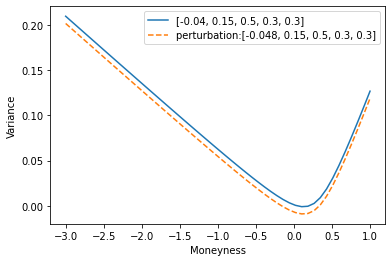

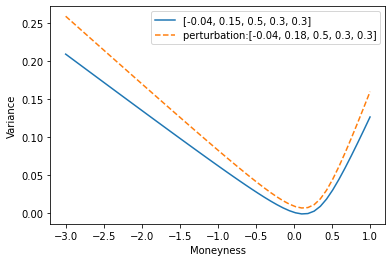

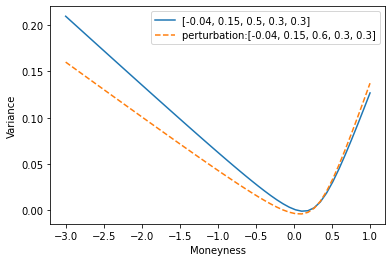

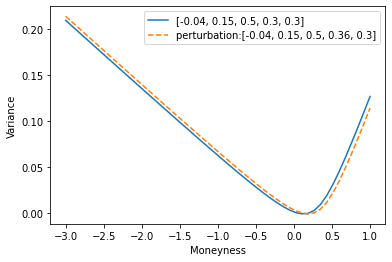

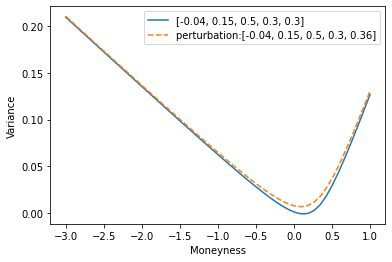

In [42]:
def getSVICurve (parameters, moneyness):
    a = parameters[0]
    b = parameters[1]
    rho = parameters[2]
    m = parameters[3]
    sigma = parameters[4]
    return [a+b*(rho*(k-m)+np.sqrt((k-m)**2 + sigma**2)) for k in moneyness]

moneyness = np.linspace(-3,1,50)
parameters = [-0.04, 0.15, 0.5, 0.3, 0.3]
pert = 1.2 # perturbation of 20%
for i in range(len(parameters)):
    plt.plot(moneyness, getSVICurve(parameters, moneyness), label=parameters)
    perturbation = [parameters[p]*pert if p==i else parameters[p] for p in range(len(parameters))]
    plt.plot(moneyness, getSVICurve(perturbation, moneyness), linestyle='dashed', label='perturbation:'+str(perturbation))
    plt.xlabel('Moneyness')
    plt.ylabel('Variance')
    plt.legend(loc='best')
    plt.show()

In [30]:
## SVI value
def sviCurve(a, b, rho, m, tau, k):
    y = a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + tau ** 2))
    if y>=0:
        return np.sqrt(y) # it returns the square root of the variance
    else:
        return 0
      
## first derivate of SVI formula
def sviCurveDerivate(b, rho, m, tau, k):
    return b * (rho + (k - m) / np.sqrt((k - m) ** 2 + tau ** 2))

## second derivate of SVI formula
def sviCurve2ndDerivate(b, m, tau, k):
    return b * tau * tau / np.power((k - m) ** 2 + tau ** 2, 1.5)

## g-function used to check butterfly arbitrage
def gFunction(a, b, rho, m, tau, S, time2Maturity, vecStrike):
    moneyness = [np.log(k / S) for k in vecStrike]
    g = []
    for k in moneyness:
        w = (sviCurve(a, b, rho, m, tau, k)**2) * time2Maturity
        wd = sviCurveDerivate(b, rho, m, tau, k) * time2Maturity
        wdd = sviCurve2ndDerivate(b, m, tau, k) * time2Maturity
        if w!=0:
            g.append((1 - k * wd / (2 * w)) ** 2 - (wd * wd / 4) * (1 / w + 0.25) + wdd / 2)
        else:
            g.append(-1)
    return g

In [61]:
#=====================================================================================
## functions for optimization
#=====================================================================================
#### butterlfy arbitrage verification:
# volCoef-> array storing SVI parameters
# vecStrikePrice-> array containing strike prices
# S-> spot price
def butterflyArbitrage(volCoef, S, time2Maturity, vecStrikePrice):    
    a = volCoef[0]
    b = volCoef[1]
    rho = volCoef[2]
    m = volCoef[3]
    tau = volCoef[4]
    g = gFunction(a, b, rho, m, tau, S, time2Maturity, vecStrikePrice)
    return np.exp([0 if gi>=0 else 1 for gi in g])

#### check if calculated value is within bid-ask spread
# pAdjusted-> array of adjusted values
# bid, ask-> arrays with the minimum and maximum values of the market
def envelopeCondition(pAdjusted, bid, ask):
    return np.exp(np.clip([0 if (pi>=bi and pi<=ai) else 2*np.fabs(pi-(ai+bi)/2)/(ai-bi) for pi, bi, ai in zip(pAdjusted, bid, ask)],
                          a_min=None,
                          a_max=10))

#### obtain price of an option by Black-Scholes model
# optionType-> string 'Call' or 'Put'
# volCoef-> array storing SVI parameters
# vecStrikePrice-> array containing strike prices
def optionPrice(optionType, S, r, volCoef, time2Maturity, vecStrikePrice):
    moneyness = [np.log(k / S) for k in vecStrikePrice]
    optionPriceList=[]
    for k, mn in zip(vecStrikePrice, moneyness):
        vol = sviCurve(volCoef[0], volCoef[1], volCoef[2], volCoef[3], volCoef[4], mn)
        if vol!=0:
            if optionType == "Call":
                optionPriceList.append(BS.Call.Price(S, k, r, vol,time2Maturity))
            elif optionType == "Put":
                optionPriceList.append(Put.Price(S, k, r, vol,time2Maturity))
        else:
            optionPriceList.append(S)
    return optionPriceList

#### objective function
# X-> array with SVI parameters
# optionType-> string 'Call' or 'Put'
# volMarket, bid, ask-> arrays with market data of implied volatility
# optionType-> string 'Call' or 'Put'
def globalOptimization(X, volMarket, bid, ask, optionType, S0, time2Maturity, vecStrikePrice, r):
    moneyness = [np.log(k / S0) for k in vecStrikePrice]
    volAdjusted = getSVICurve(X, moneyness)    
    
    pAdjusted = optionPrice(optionType=optionType,
                            S=S0,
                            r=r,
                            volCoef=X,
                            time2Maturity=time2Maturity,
                            vecStrikePrice=vecStrikePrice)
    ## penalizations
    consButterfly = butterflyArbitrage(X, S0, time2Maturity, vecStrikePrice)
    consEnvelope = envelopeCondition(pAdjusted, bid, ask)

    OF = np.array([(volAdj/volMar - 1)*bi*ei for volAdj,volMar, bi,ei in zip(volAdjusted, volMarket, consButterfly, consEnvelope)])
    return np.sum(OF**2)

## follow-up function
def callbackFunction(X, convergence):
    xProgress.append(X) # global variable containing progress of the optimization process

def d1(S, K, r, sigma, T):
    return (np.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*np.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*np.sqrt(T)
'''
Input parameters:
S -> asset price
K -> strike price
r -> interest rate
sigma -> volatility
T -> time to maturity
'''
class Put:
    def Price(S, K, r, sigma, T):
        return np.maximum(K-S,0) if T==0 else K*np.exp(-r*T)*scistat.norm.cdf(-1*d2(S, K, r, sigma, T)) - S*scistat.norm.cdf(-1*d1(S, K, r, sigma, T))

    def Delta(S, K, r, sigma, T):
        return scistat.norm.cdf(d1(S, K, r, sigma, T)) - 1

    def Gamma(S, K, r, sigma, T):
        return scistat.norm.pdf(d1(S, K, r, sigma, T))/(S*sigma*np.sqrt(T))

    def Vega(S, K, r, sigma, T):
        return S*scistat.norm.pdf(d1(S, K, r, sigma, T))*np.sqrt(T)

    def Theta(S, K, r, sigma, T):
        aux1 = -S*scistat.norm.pdf(d1(S, K, r, sigma, T))*sigma/(2*np.sqrt(T))
        aux2 = r*K*np.exp(-r*T)*scistat.norm.cdf(-1*d2(S, K, r, sigma, T))
        return aux1+aux2

    def Rho(S, K, r, sigma, T):
        return -K*T*np.exp(-r*T)*scistat.norm.cdf(-1*d2(S, K, r, sigma, T))

    def Get_range_value(Smin, Smax, Sstep, K, r, sigma, T, num_curves, value="Price"):
        vec = np.linspace(Smin, Smax, (Smax - Smin) / Sstep)
        vecT = np.linspace(0,T,num_curves, endpoint=True)
        if value=="Price":
            return vec,vecT, [[Put.Price(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Delta":
            return vec, vecT, [[Put.Delta(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Gamma":
            return vec, vecT, [[Put.Gamma(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Vega":
            return vec, vecT, [[Put.Vega(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Theta":
            return vec, vecT, [[Put.Theta(S, K, r, sigma, t) for S in vec] for t in vecT]
        elif value=="Rho":
            return vec, vecT, [[Put.Rho(S, K, r, sigma, t) for S in vec] for t in vecT]


In [62]:
def getVolatility(optType, marketPrice, S0, time2Maturity, vecStrike, r, time):
    bounds = [(0,2)]
    if optType == "Call":
        opt = BS.Call
    elif optType == "Put":
        opt = Put
    vol = []
    for k, mp in zip(vecStrike, marketPrice):
        args = (opt, S0, k, r, time2Maturity, mp)
        volOptimResults = sciopt.differential_evolution(volMarket, args = args, bounds=bounds, tol=1E-8)
        vol.append(volOptimResults.x)
    return vol

def volMarket(x, opt, S0, k, r, time2Maturity, realPrice):
    return (opt.Price(S0, k, r, x, time2Maturity) - realPrice)**2

In [65]:
def getData(optTypeName, op_chain, S0, time2Maturity, r):
    #optionDataFrame = pd.read_csv(fileName, sep=sep)
    optionDataFrame = op_chain
    optionDataFrame['Bid'] = optionDataFrame["Bid"].replace(to_replace=np.NaN, value=0.)
    optionDataFrame['Moneyness'] = [np.log(k/S0) for k in optionDataFrame['Strike']]
    optionDataFrame['volMarketData'] = getVolatility(optTypeName,
                                                     optionDataFrame['Midpoint'],
                                                     S0,
                                                     time2Maturity,
                                                     optionDataFrame['Strike'],
                                                     r,
                                                     time2Maturity)
    optionDataFrame['volBidMarketData'] = getVolatility(optTypeName,
                                                     optionDataFrame['Bid'],
                                                     S0,
                                                     time2Maturity,
                                                     optionDataFrame['Strike'],
                                                     r,
                                                     time2Maturity)
    optionDataFrame['volAskMarketData'] = getVolatility(optTypeName,
                                                     optionDataFrame['Ask'],
                                                     S0,
                                                     time2Maturity,
                                                     optionDataFrame['Strike'],
                                                     r,
                                                     time2Maturity)

    return optionDataFrame



def vol_surface_calibration(strike, time2Maturity, S0, r):
    
    op_chain = spx_oc
    #op_chain = get_spx_vol_data(time2Maturity)
    optTypeName = 'Put'
    
    optionDF = getData(optTypeName,op_chain, S0, time2Maturity, r)
    print(optionDF)
    args = (optionDF['volMarketData'],
            optionDF['volBidMarketData'],
            optionDF['volAskMarketData'],
            optTypeName, S0,
            time2Maturity,
            optionDF['Strike'],
            r)
    boundsParameters = [(0.,5.), (-5.,5.), (-5.,5.), (-5.,5.), (0.,5.)]
    print("Optimization begins...")
    xProgress=[]
    resultsOptimization = sciopt.differential_evolution(globalOptimization,
                                                        args = args,
                                                        callback=callbackFunction,
                                                        bounds = boundsParameters,
                                                        polish=True,
                                                        maxiter=1000,
                                                        tol = 1E-6)
    print(resultsOptimization)
    return resultsOptimization

def getVolData(strike, time2Maturity, S0, r):
    moneyness = np.log(strike/S0)
    resultsOptimization = vol_surface_calibration(strike, time2Maturity, S0, r)
    return getSVICurve(resultsOptimization.x, moneyness)

In [66]:
spx = yf.Ticker('^SPX')
    
maturities = spx.options

In [67]:
maturities

('2022-12-27',
 '2022-12-28',
 '2022-12-29',
 '2022-12-30',
 '2023-01-03',
 '2023-01-04',
 '2023-01-05',
 '2023-01-06',
 '2023-01-09',
 '2023-01-10',
 '2023-01-11',
 '2023-01-12',
 '2023-01-13',
 '2023-01-17',
 '2023-01-20',
 '2023-01-23',
 '2023-01-27',
 '2023-01-30',
 '2023-01-31',
 '2023-02-03',
 '2023-02-06',
 '2023-02-17',
 '2023-02-28',
 '2023-03-17',
 '2023-03-31',
 '2023-04-21',
 '2023-04-28',
 '2023-05-19',
 '2023-05-31',
 '2023-06-16',
 '2023-06-30',
 '2023-07-21',
 '2023-08-18',
 '2023-09-15',
 '2023-09-29',
 '2023-10-20',
 '2023-11-17',
 '2023-12-15',
 '2024-01-19',
 '2024-03-15',
 '2024-06-21',
 '2024-12-20',
 '2025-12-19',
 '2026-03-20',
 '2026-12-18',
 '2027-12-17')

In [68]:
spx_oc = spx.option_chain('2023-05-31').puts
spx_oc = spx_oc[['strike', 'bid', 'ask']]
spx_oc = spx_oc.rename(columns={'strike': 'Strike', 'bid': 'Bid', 'ask': 'Ask'})
spx_oc['Midpoint'] = spx_oc.apply(lambda row: (row.Bid + row.Ask)/2, axis=1)
spx_oc    

,Strike,Bid,Ask,Midpoint
0,1000.0,0.45,0.8,0.625
1,1200.0,0.85,1.2,1.025
2,1800.0,3.00,3.5,3.250
3,2000.0,4.30,4.9,4.600
4,2200.0,6.10,6.7,6.400
...,...,...,...,...
99,4250.0,412.00,424.5,418.250
100,4300.0,447.20,460.3,453.750
101,4350.0,484.40,498.1,491.250
102,4500.0,606.80,622.1,614.450


In [69]:
vol = getVolData(3000, 6, 3852, 0.2)
vol

     Strike     Bid    Ask  Midpoint  Moneyness          volMarketData  \
0    1000.0    0.45    0.8     0.625  -1.348592   [0.3684029692828664]   
1    1200.0    0.85    1.2     1.025  -1.166271   [0.3583065284384511]   
2    1800.0    3.00    3.5     3.250  -0.760806  [0.33689062339129394]   
3    2000.0    4.30    4.9     4.600  -0.655445  [0.33321416917625135]   
4    2200.0    6.10    6.7     6.400  -0.560135  [0.33074082390215487]   
..      ...     ...    ...       ...        ...                    ...   
99   4250.0  412.00  424.5   418.250   0.098326   [0.6407615273464103]   
100  4300.0  447.20  460.3   453.750   0.110023   [0.6625978100760448]   
101  4350.0  484.40  498.1   491.250   0.121583   [0.6856780935296922]   
102  4500.0  606.80  622.1   614.450   0.155485   [0.7622031591801065]   
103  4700.0  788.00  804.4   796.200   0.198970   [0.8795612672276051]   

          volBidMarketData       volAskMarketData  
0    [0.35721233417837384]  [0.37744037131814356]  
1    [0

NameError: name 'xProgress' is not defined

In [2]:
def get_spx_vol_data(maturity):
    
    print("Fetching SPX market data.....")
    spx = yf.Ticker('^SPX')
    
    mat_date = date.today() + timedelta(days=int(maturity * 365))
    maturities = spx.options
    new_mats = []
    for i in range(len(maturities)):
        
        new_mats.append(datetime.strptime(maturities[i], "%Y-%m-%d").date())
        
    closest_mat = nearest(new_mats, mat_date)
    spx_oc = spx.option_chain(closest_mat.strftime('%Y-%m-%d')).puts
    spx_oc = spx_oc[['strike', 'bid', 'ask']]
    spx_oc = spx_oc.rename(columns={'strike': 'Strike', 'bid': 'Bid', 'ask': 'Ask'})
    spx_oc['Midpoint'] = spx_oc.apply(lambda row: (row.Bid + row.Ask)/2, axis=1)
    return spx_oc

In [7]:
get_spx_vol_data(0.5)

Fetching SPX market data.....


NameError: name 'nearest' is not defined